In [1]:
from zoish.feature_selectors.zoish_feature_selector import ScallyShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:

SFC_XGBCLS_OPTUNA = ScallyShapFeatureSelector(
        n_features=5,
        estimator=xgboost.XGBClassifier(),
        estimator_params={
            "max_depth": [2, 3],
            "min_child_weight": [0.1, 0.9],
            "gamma": [1, 9],
        },
        hyper_parameter_optimization_method="optuna",
        shap_version="v0",
        measure_of_accuracy="f1",
        list_of_obligatory_features=[],
        test_size=0.33,
        cv=KFold(n_splits=3, random_state=42, shuffle=True),
        with_shap_summary_plot=True,
        with_stratified=False,
        verbose=0,
        random_state=42,
        n_jobs=-1,
        n_iter=100,
        eval_metric="auc",
        number_of_trials=20,
        sampler=TPESampler(),
        pruner=HyperbandPruner(),
    )


Setting value for n_features
Setting value for estimator
Getting value for estimator
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Gettin

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', SFC_XGBCLS_OPTUNA),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

[I 2022-07-25 15:42:00,622] A new study created in memory with name: no-name-d3232ac6-2464-4749-863d-9e27881c8b3a


Getting value for hyper_parameter_optimization_method
Getting value for hyper_parameter_optimization_method
Getting value for hyper_parameter_optimization_method
Getting value for estimator
Getting value for measure_of_accuracy
Getting value for estimator_params
Getting value for verbose
Getting value for test_size
Getting value for random_state
Getting value for eval_metric
Getting value for number_of_trials
Getting value for sampler
Getting value for pruner
Getting value for with_stratified
       age  workclass  fnlwgt  education  education-num  marital-status  \
27476   35          1  177102          4              9               2   
10052   61          1  193479          4              9               4   
11713   24          3  169624          4              9               2   
2513    47          3  174525          4              9               5   
12308   26          1  175789          4              9               2   
...    ...        ...     ...        ...            

[I 2022-07-25 15:42:00,765] Trial 0 finished with value: 0.6490747087045922 and parameters: {'max_depth': 3, 'min_child_weight': 0.6143949968843346, 'gamma': 3.8856906963864057}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85871
[3]	validation-auc:0.87262
[4]	validation-auc:0.88612
[5]	validation-auc:0.89044
[6]	validation-auc:0.89237
[7]	validation-auc:0.89322
[8]	validation-auc:0.89807
[9]	validation-auc:0.90037


[I 2022-07-25 15:42:00,869] Trial 1 finished with value: 0.6225839267548322 and parameters: {'max_depth': 2, 'min_child_weight': 0.44987033391430065, 'gamma': 8.136395547089071}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89816
[4]	validation-auc:0.89971
[5]	validation-auc:0.90367
[6]	validation-auc:0.90642
[7]	validation-auc:0.90934
[8]	validation-auc:0.90985
[9]	validation-auc:0.91075


[I 2022-07-25 15:42:00,979] Trial 2 finished with value: 0.6408304498269897 and parameters: {'max_depth': 3, 'min_child_weight': 0.8468210582576646, 'gamma': 1.0515765820499983}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194


[I 2022-07-25 15:42:01,005] Trial 3 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85911
[3]	validation-auc:0.87281
[4]	validation-auc:0.88634
[5]	validation-auc:0.89025
[6]	validation-auc:0.89120
[7]	validation-auc:0.89633
[8]	validation-auc:0.89686
[9]	validation-auc:0.90157


[I 2022-07-25 15:42:01,092] Trial 4 finished with value: 0.6315429353404037 and parameters: {'max_depth': 2, 'min_child_weight': 0.8530099493817311, 'gamma': 6.5401602964739025}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85911
[3]	validation-auc:0.87281
[4]	validation-auc:0.88634
[5]	validation-auc:0.89025
[6]	validation-auc:0.89120
[7]	validation-auc:0.89633
[8]	validation-auc:0.89686
[9]	validation-auc:0.90039


[I 2022-07-25 15:42:01,191] Trial 5 finished with value: 0.6324786324786325 and parameters: {'max_depth': 2, 'min_child_weight': 0.16713703885792935, 'gamma': 7.06990520469909}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917


[I 2022-07-25 15:42:01,231] Trial 6 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917


[I 2022-07-25 15:42:01,278] Trial 7 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89816
[4]	validation-auc:0.89969
[5]	validation-auc:0.90319
[6]	validation-auc:0.90733
[7]	validation-auc:0.90909
[8]	validation-auc:0.90916
[9]	validation-auc:0.91028


[I 2022-07-25 15:42:01,366] Trial 8 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89816
[4]	validation-auc:0.89969
[5]	validation-auc:0.90319
[6]	validation-auc:0.90765
[7]	validation-auc:0.90821
[8]	validation-auc:0.90893
[9]	validation-auc:0.91035


[I 2022-07-25 15:42:01,448] Trial 9 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85911
[3]	validation-auc:0.87281
[4]	validation-auc:0.88634
[5]	validation-auc:0.89025
[6]	validation-auc:0.89155
[7]	validation-auc:0.89720
[8]	validation-auc:0.89813
[9]	validation-auc:0.90243


[I 2022-07-25 15:42:01,530] Trial 10 finished with value: 0.6322624743677375 and parameters: {'max_depth': 2, 'min_child_weight': 0.4562536800896443, 'gamma': 2.847051866470565}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89789


[I 2022-07-25 15:42:01,572] Trial 11 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89789


[I 2022-07-25 15:42:01,611] Trial 12 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89816
[4]	validation-auc:0.89969
[5]	validation-auc:0.90319
[6]	validation-auc:0.90765
[7]	validation-auc:0.90821
[8]	validation-auc:0.90893


[I 2022-07-25 15:42:01,687] Trial 13 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194


[I 2022-07-25 15:42:01,724] Trial 14 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194


[I 2022-07-25 15:42:01,762] Trial 15 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85911
[3]	validation-auc:0.87281
[4]	validation-auc:0.88634
[5]	validation-auc:0.89025
[6]	validation-auc:0.89155
[7]	validation-auc:0.89720
[8]	validation-auc:0.89813
[9]	validation-auc:0.90243


[I 2022-07-25 15:42:01,849] Trial 16 finished with value: 0.6322624743677375 and parameters: {'max_depth': 2, 'min_child_weight': 0.5392878452337309, 'gamma': 2.670718277948712}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85911
[3]	validation-auc:0.87281
[4]	validation-auc:0.88634
[5]	validation-auc:0.89025
[6]	validation-auc:0.89155
[7]	validation-auc:0.89720
[8]	validation-auc:0.89813
[9]	validation-auc:0.90243


[I 2022-07-25 15:42:01,938] Trial 17 finished with value: 0.6322624743677375 and parameters: {'max_depth': 2, 'min_child_weight': 0.5948390666038161, 'gamma': 4.674831538418772}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.85926
[1]	validation-auc:0.87514
[2]	validation-auc:0.88917
[3]	validation-auc:0.89816
[4]	validation-auc:0.89971
[5]	validation-auc:0.90367
[6]	validation-auc:0.90642
[7]	validation-auc:0.90934
[8]	validation-auc:0.90985
[9]	validation-auc:0.91075


[I 2022-07-25 15:42:02,046] Trial 18 finished with value: 0.6408304498269897 and parameters: {'max_depth': 3, 'min_child_weight': 0.7429279599091139, 'gamma': 1.2150113190474134}. Best is trial 0 with value: 0.6490747087045922.


[0]	validation-auc:0.82538
[1]	validation-auc:0.84194
[2]	validation-auc:0.85911
[3]	validation-auc:0.87281
[4]	validation-auc:0.88634
[5]	validation-auc:0.89025
[6]	validation-auc:0.89155
[7]	validation-auc:0.89720
[8]	validation-auc:0.89813
[9]	validation-auc:0.90243


[I 2022-07-25 15:42:02,141] Trial 19 finished with value: 0.6322624743677375 and parameters: {'max_depth': 2, 'min_child_weight': 0.7497643275330873, 'gamma': 4.164903086198162}. Best is trial 0 with value: 0.6490747087045922.


{'max_depth': 3, 'min_child_weight': 0.6143949968843346, 'gamma': 3.8856906963864057}
[0]	validation-rmse:0.42537
[1]	validation-rmse:0.38315
[2]	validation-rmse:0.35846
[3]	validation-rmse:0.34306
[4]	validation-rmse:0.33453
[5]	validation-rmse:0.32833
[6]	validation-rmse:0.32396
[7]	validation-rmse:0.32138
[8]	validation-rmse:0.32010
[9]	validation-rmse:0.31752
Setting value for best_estimator
Getting value for estimator
Getting value for best_estimator
Getting value for shap_version
Getting value for n_jobs
.values =
array([[-0.05766597, -0.00091042,  0.00026423, ..., -0.00520326,
        -0.01761336,  0.        ],
       [-0.03810894, -0.00211806,  0.00026423, ..., -0.00554902,
        -0.01312835,  0.        ],
       [ 0.03157522, -0.00211806,  0.00045955, ..., -0.00471693,
        -0.01577177,  0.        ],
       ...,
       [ 0.0358651 , -0.00211806,  0.00232863, ..., -0.00720389,
         0.06241207,  0.        ],
       [-0.09191545, -0.00091042, -0.00536114, ..., -0.0059171

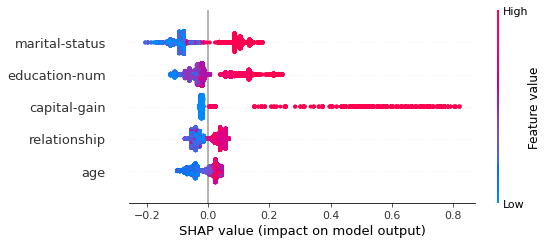

Getting value for estimator
Setting value for importance_df
Getting value for importance_df
                 0         1
0              age  0.032061
1        workclass  0.003375
2           fnlwgt  0.001323
3        education       0.0
4    education-num  0.057741
5   marital-status  0.097023
6       occupation  0.025032
7     relationship  0.036853
8             race       0.0
9              sex       0.0
10    capital-gain  0.046402
11    capital-loss  0.012001
12  hours-per-week  0.028178
13  native-country       0.0
Getting value for importance_df
Getting value for importance_df
       column_name shap_importance
0              age        0.032061
1        workclass        0.003375
2           fnlwgt        0.001323
3        education             0.0
4    education-num        0.057741
5   marital-status        0.097023
6       occupation        0.025032
7     relationship        0.036853
8             race             0.0
9              sex             0.0
10    capital-gain      

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.612790188348664
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      8158
           1       0.71      0.54      0.61      2588

    accuracy                           0.84     10746
   macro avg       0.79      0.73      0.75     10746
weighted avg       0.83      0.84      0.83     10746

Confusion matrix : 
[[7579  579]
 [1189 1399]]
